In [3]:
import numpy as np
import astropy.units as u
import astropy.constants as con
import emcee
import corner
import speclite as speclite; from speclite import filters
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from matplotlib.artist import Artist
from chromatic import *
from scipy.optimize import minimize
from scipy.optimize import curve_fit


params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
plt.style.use('seaborn-deep')

## Calculate the scale height

In [ ]:
AB = 0.3 #bond albedo
Teff = 3600
#Teq = ((1-AB)*Teff**4)**(1/4) * u.K #600 * u.K 
Teq = 600 * u.K 
Rp = 4.15 * u.R_earth
Mp = 17 * u.M_earth # other listed values are 11 and 20 Me
mu = 10 # that's for an H2 atmosphere
transit_depth = 0.0512**2
deltaD_atm = (2*con.k_B*Teq*Rp*transit_depth) / (mu * con.m_p * con.G * Mp)

In [ ]:
one_scale_height = deltaD_atm.decompose()

In [ ]:
Rp = one_scale_height/transit_depth + 1
print(Rp)

## Calculate AU Mic's T$_{\rm{eff}}\pm\sigma$T$_{\rm{eff}}$ based on observed luminosity and radius

In [ ]:
L = np.random.normal(0.09,0.02,100000) # Plavchan+ 2009
R = np.random.normal(0.862,0.052,100000) # VLTI measurement
Teff = 5780.0*((L/(R**2))**(1./4.))

In [ ]:
np.median(Teff)

In [ ]:
np.percentile(Teff, [15.9, 50., 84.1])

## Calculate the Doppler-broadened linewidth, $\Delta\lambda$

In [ ]:
vsini = 8.0 * u.km/u.s # from vsini
lambda_i = np.linspace(0.55,0.89,100)*u.micron
delta_lambda = lambda_i * ( (vsini/con.c)/(1.0+(vsini/con.c)) )
delta_lambda = (delta_lambda.decompose()) * 1e9 * u.nm/u.m

plt.figure()
plt.plot(lambda_i,delta_lambda)
plt.xlabel(r'$\lambda_0$ ($\mu$m)')
plt.ylabel(r'$\Delta\lambda$ (nm)')

with Doppler broadening around 0.015-0.024 nm in the NRES bandpass, it is appropriate for us to continue binning the spectra to 0.05 nm so that our binsize accounts for doppler broadening

In [20]:
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.distributions.mixture_rvs import mixture_rvs

In [190]:
nsteps = 3000
modeltype = f'Final_Teff_Phot_Spec'
modelname = 'Teff + Phot + Spec'
visits = ['combined']
orders_I_care_about = [53,58,61,76]

f_kde = [0,0,0,0]
df_kde = [0,0,0,0]
Tspot_kde =[0,0,0,0]             
Tamb_kde = [0,0,0,0]             
Trat_kde = [0,0,0,0]             

i=0
for order in orders_I_care_about:
    visit = visits[0]
    label = f'{visit}_{order}_{modeltype}'
    samples_file_label = label+f'_{nsteps}steps'
    '''
    READ IN THE MCMC SAMPLES
    '''
    reader = emcee.backends.HDFBackend(f'../data/samples/{samples_file_label}.h5')
    sampler = reader.get_chain(discard=int(0.25*nsteps), flat=True)
    samples = sampler.reshape((-1, 4)).T
    
    kde = sm.nonparametric.KDEUnivariate(samples[0])
    kde.fit()  # Estimate the densities
    f_kde[i] = kde

    kde = sm.nonparametric.KDEUnivariate(samples[1])
    kde.fit()  # Estimate the densities
    df_kde[i] = kde   

    kde = sm.nonparametric.KDEUnivariate(samples[2])
    kde.fit()  # Estimate the densities
    Tspot_kde[i] = kde              

    kde = sm.nonparametric.KDEUnivariate(samples[3])
    kde.fit()  # Estimate the densities
    Tamb_kde[i] = kde
    
    kde = sm.nonparametric.KDEUnivariate(samples[2]/samples[3])
    kde.fit()  # Estimate the densities
    Trat_kde[i] = kde
    
    i+=1

In [231]:
f_density = [0,0,0,0]
df_density = [0,0,0,0]
Tspot_density = [0,0,0,0]
Tamb_density = [0,0,0,0]
Trat_density = [0,0,0,0]

ref_f_array = np.linspace(0.1,0.5,500)
ref_df_array = np.linspace(0.01,0.15,500)
ref_Tspot_array = np.linspace(2700,3800,500)
ref_Tamb_array = np.linspace(3600,4100,500)
ref_Trat_array = np.linspace(0.6,1.2,500)

i = 0
for i in range(len(f_density)):
   
    interp_f = np.interp(ref_f_array,f_kde[i].support,f_kde[i].density)
    interp_df = np.interp(ref_df_array,df_kde[i].support,df_kde[i].density)
    interp_Tspot = np.interp(ref_Tspot_array,Tspot_kde[i].support,Tspot_kde[i].density)
    interp_Tamb = np.interp(ref_Tamb_array,Tamb_kde[i].support,Tamb_kde[i].density)
    interp_Trat = np.interp(ref_Trat_array,Trat_kde[i].support,Trat_kde[i].density)
    
    f_density[i] = interp_f
    df_density[i] = interp_df
    Tspot_density[i] = interp_Tspot
    Tamb_density[i] = interp_Tamb
    Trat_density[i] = interp_Trat

    i+=1

In [232]:
f_posterior = np.prod(f_density,axis=0)
df_posterior = np.prod(df_density,axis=0)
Tspot_posterior = np.prod(Tspot_density,axis=0)
Tamb_posterior = np.prod(Tamb_density,axis=0)
Trat_posterior = np.prod(Trat_density,axis=0)


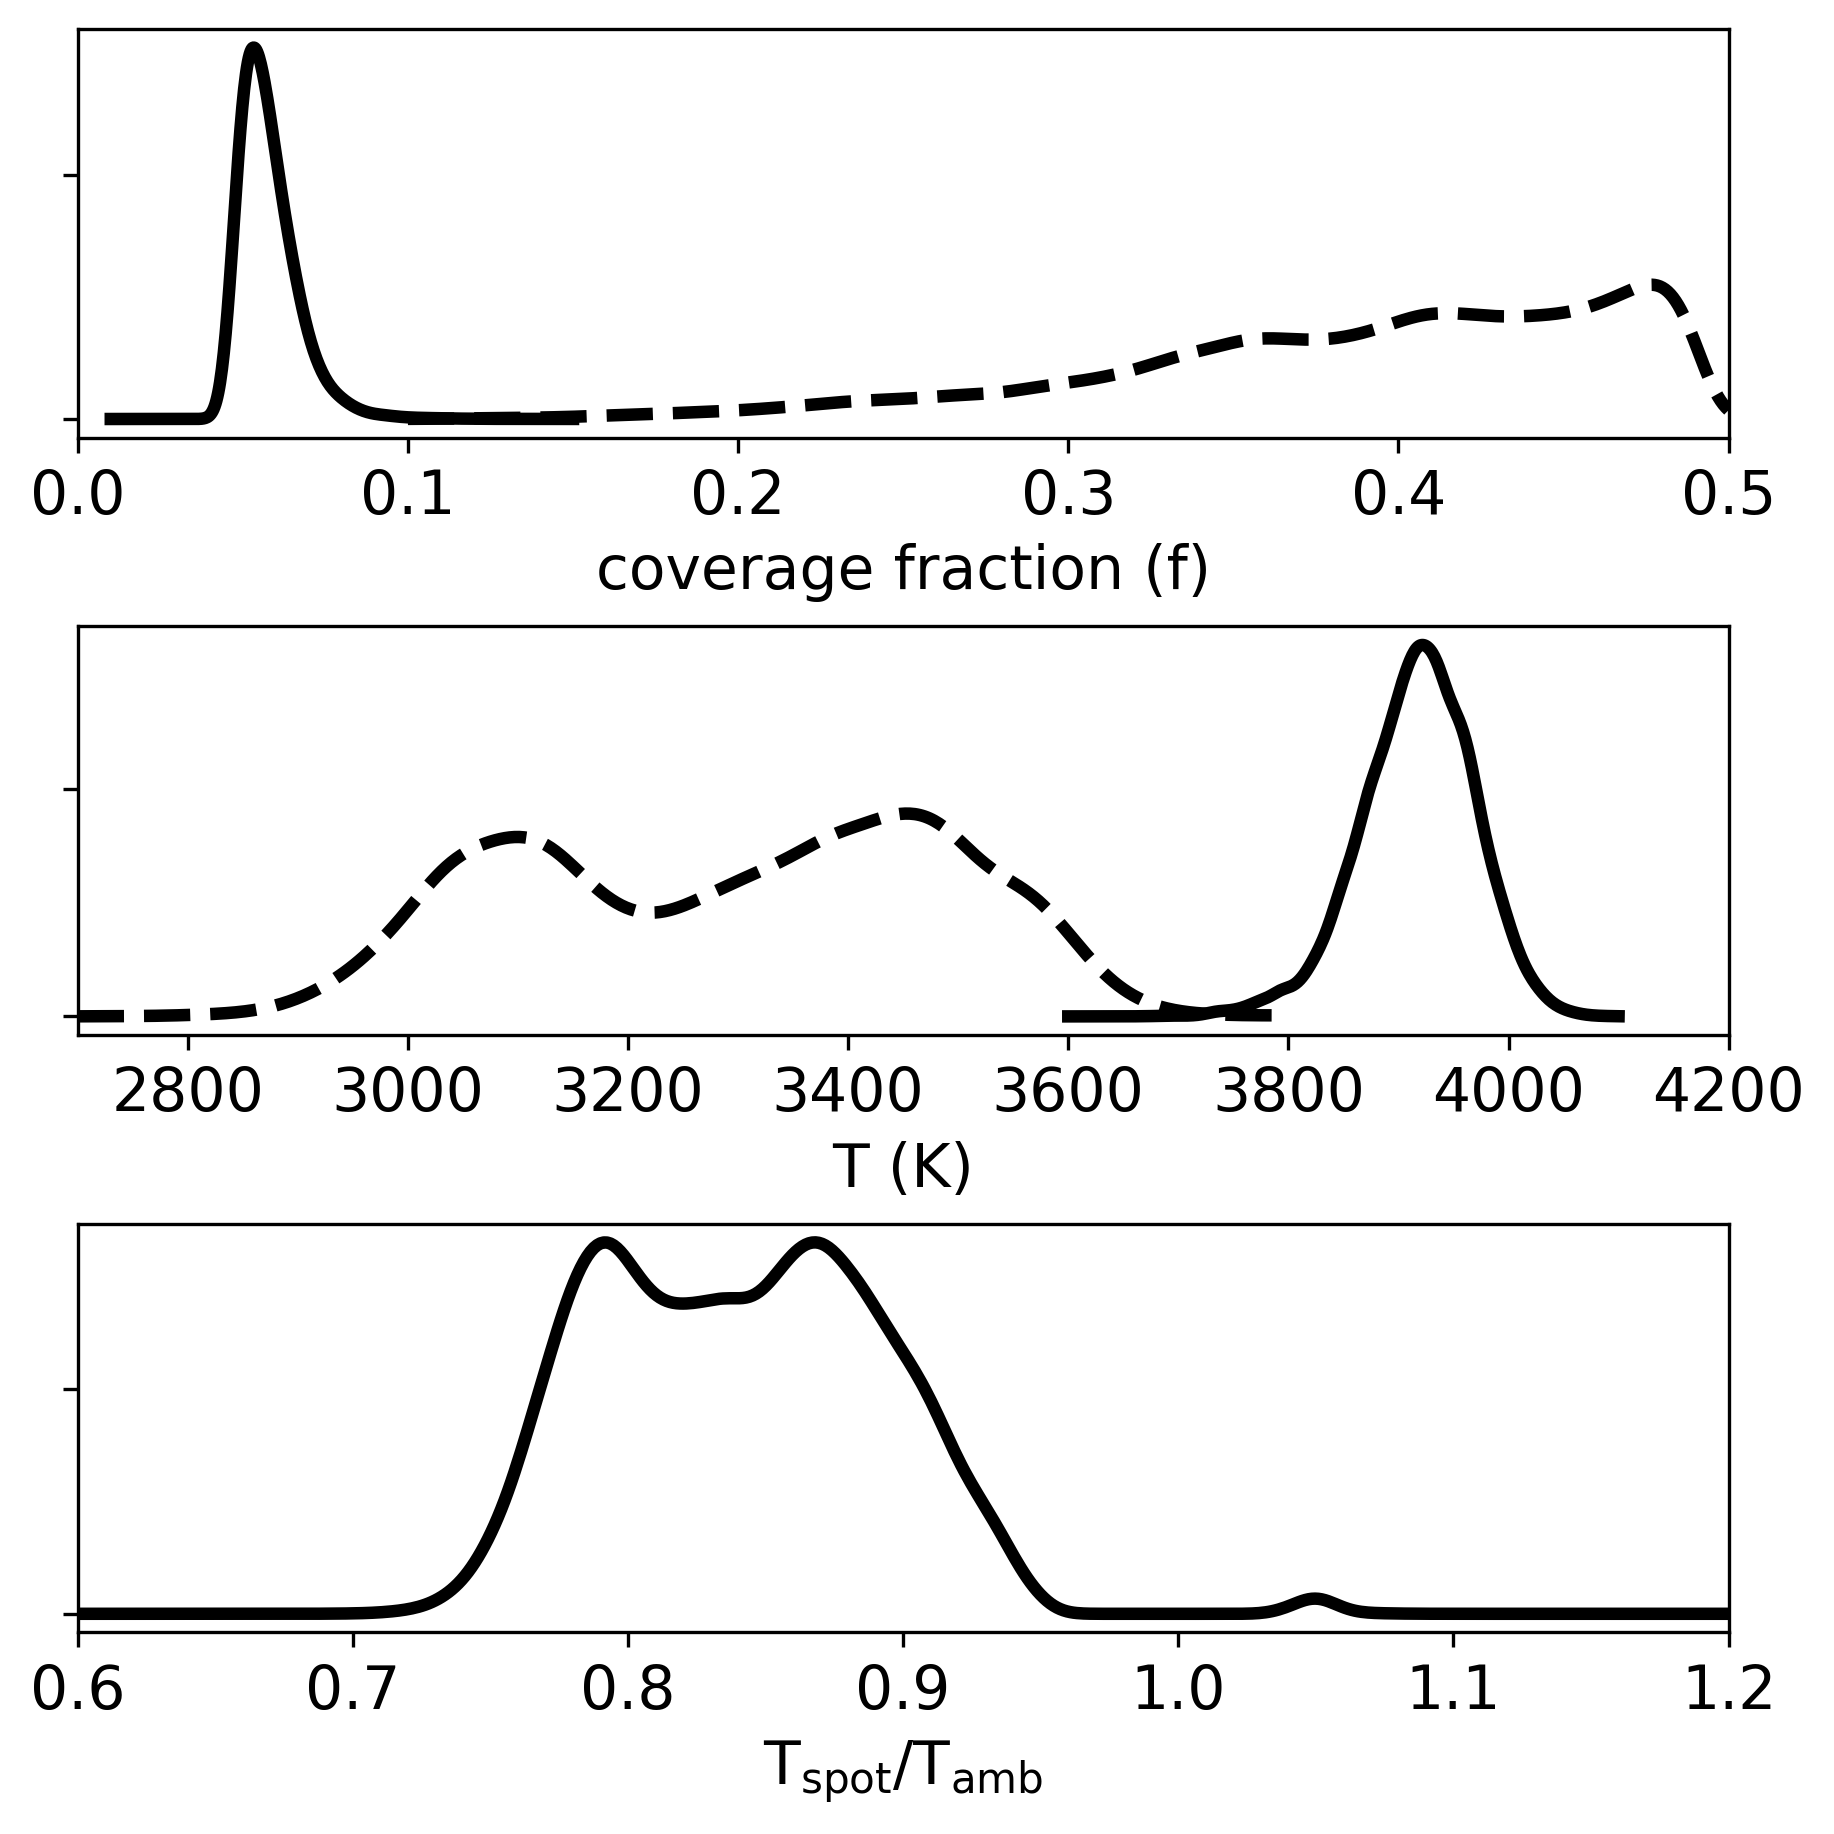

In [233]:
fig,axs = plt.subplots(3,1,figsize=(6,6))

axs[0].plot(ref_f_array, f_posterior/np.sum(f_posterior), lw=3, zorder=10,color='k',label=r'$f_{\rm spot}$',linestyle='--')
axs[0].plot(ref_df_array, df_posterior/np.sum(df_posterior), lw=3, zorder=10,color='k',label=r'$\Delta~f_{\rm spot}$')
axs[1].plot(ref_Tspot_array, Tspot_posterior/np.sum(Tspot_posterior), lw=3, zorder=10,color='k',label=r'$\rm T_{spot}$',linestyle='--')
axs[1].plot(ref_Tamb_array, Tamb_posterior/np.sum(Tamb_posterior), lw=3, zorder=10,color='k',label=r'$\rm T_{amb}$')
axs[2].plot(ref_Trat_array, Trat_posterior/np.sum(Trat_posterior), lw=3, zorder=10,color='k',label=r'$\rm T_{spot}T_{amb}$')

# axs[0].axvline(0.0535, lw=2, zorder=100,label='0.0535',color='coral')
# axs[1].axvline(3450, lw=2, zorder=100,label='3450 K',color='red')
# axs[1].axvline(3922, lw=2, zorder=100,label='3900 K',color='blue')
# axs[1].axvline(3100, lw=2, zorder=100,label='3100 K',color='purple')

axs[0].set_xlim(0.0,0.5)
axs[0].set_xlabel(r'coverage fraction (f)')
axs[1].set_xlim(2700,4200)
axs[1].set_xlabel(r'T (K)')
axs[2].set_xlim(0.6,1.2)
axs[2].set_xlabel(r'$\rm T_{spot}/T_{amb}$')

axs[0].set(yticklabels=[])
axs[1].set(yticklabels=[])
axs[2].set(yticklabels=[])

# axs[0].legend(loc='upper right',fontsize=9)
# axs[1].legend(loc='upper left',fontsize=9)


plt.savefig('posteriors.png')